In [1]:
import numpy as np
import pandas as pd
from itertools import groupby
from operator import itemgetter

from scipy.optimize import minimize
from scipy.spatial.distance import cdist
import odor_stat_calculations as osc
from scipy.stats import kurtosis


import matplotlib.pyplot as plt 
import seaborn as sns
from figurefirst import FigureLayout,mpl_functions
from mpl_toolkits.axes_grid1 import make_axes_locatable



2024-12-17 09:23:29.929774: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-17 09:23:29.940683: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-17 09:23:29.944082: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 09:23:30.474123: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
dfres = pd.read_hdf('/home/gorilla/An/data/Sprints/HighRes/NotWindy/NotWindyMASigned.h5') ## HighRes

In [3]:
index = osc.get_index(dfres.odor,4.5)
whiff_initiation_points = [sub[0] for sub in index]
dfres['whiff_flag'] = 0

# Set 1 for the specified indices in the 'whiff_flag' column
dfres.iloc[whiff_initiation_points, dfres.columns.get_loc('whiff_flag')] = 1

dfres['distance_along_streakline']=dfres.distance_from_source_a*dfres.xsign
dfres['nearest_from_streakline']=dfres.nearest_from_streakline*dfres.ysign

In [4]:

def avg_distance(df,index,dat): #input ; location ; storage
    i = 0
    distance_along_streakline = []
    nearest_from_streakline = []
    while i<len(index):
        distance_along_streakline.append(np.mean(df.distance_along_streakline[index[i]]))
        nearest_from_streakline.append(np.mean(df.nearest_from_streakline[index[i]]))
        i+=1
    dat['avg_distance_along_streakline']= distance_along_streakline
    dat['avg_nearest_from_streakline'] = nearest_from_streakline

def get_index_nowhiff(data, th):
    idx = [i for i, value in enumerate(data) if value < th]
    index = [list(map(itemgetter(1), g)) for k, g in groupby(enumerate(idx), lambda ix: ix[0] - ix[1])]
    return index

def avg_distance_nowhiff(df, idx, dat):
    distance_along_streakline = []
    nearest_from_streakline = []
    for indices in idx:
        if indices:  # Check if indices list is not empty
            distance_along_streakline.append(np.mean(df['distance_along_streakline'].iloc[indices]))
            nearest_from_streakline.append(np.mean(df['nearest_from_streakline'].iloc[indices]))
        else:
            distance_along_streakline.append(np.nan)
            nearest_from_streakline.append(np.nan)

    dat['avg_distance_along_streakline'] = distance_along_streakline
    dat['avg_nearest_from_streakline'] = nearest_from_streakline

def wc_wsd_nowhiff(df, idx, dat):
    wc_nowhiff = []
    std_dev_nowhiff = []
    for indices in idx:
        if indices:  # Check if indices list is not empty
            wc_nowhiff.append(np.mean(df['odor'].iloc[indices]))
            std_dev_nowhiff.append(np.std(df['odor'].iloc[indices]))
        else:
            wc_nowhiff.append(np.nan)
            std_dev_nowhiff.append(np.nan)

    dat['wc_nowhiff'] = wc_nowhiff
    dat['wsd_nowhiff'] = std_dev_nowhiff

def cal_stat(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff(df,idx,df2)
    osc.mean_avg(df,idx,df2)
    osc.encounter_frequency(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)

thres = 4.5
np.seterr(divide='ignore')
index = osc.get_index(dfres.odor,thres)
index_nowhiff = get_index_nowhiff(dfres.odor,thres)
fdf = pd.DataFrame()
fdf_nowhiff=pd.DataFrame()

cal_stat(dfres,index,fdf)
avg_distance(dfres, index, fdf)
wc_wsd_nowhiff(dfres, index_nowhiff,fdf_nowhiff)
avg_distance_nowhiff(dfres,index_nowhiff,fdf_nowhiff)

# fdf.keys()

#### Calculate LT Whiff Statistics

(-30.0, 30.0)

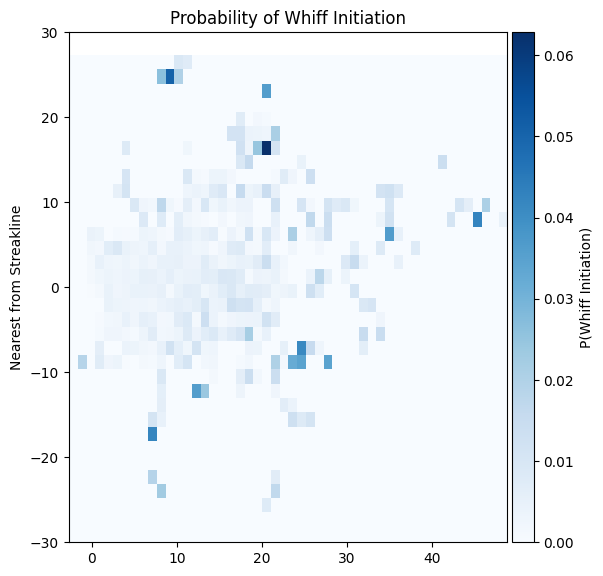

In [5]:
n_bins_x=n_bins_y=50
heatmap_whiff, xedges, yedges = np.histogram2d(dfres['distance_along_streakline'], 
                                               dfres['nearest_from_streakline'], 
                                               bins=[n_bins_x, n_bins_y], 
                                               weights=dfres['whiff_flag'])

# Histogram for total data points (irrespective of whiff initiation)
heatmap_total, _, _ = np.histogram2d(dfres['distance_along_streakline'], 
                                     dfres['nearest_from_streakline'], 
                                     bins=[n_bins_x, n_bins_y])

# Calculate the probability as number of whiff initiation points / total number of data points
with np.errstate(divide='ignore', invalid='ignore'):  # Handle division by zero
    heatmap_prob = np.divide(heatmap_whiff, heatmap_total, out=np.zeros_like(heatmap_whiff), where=heatmap_total != 0)

# Plot the original and smoothed heatmaps
f, (ax1) = plt.subplots(1, 1, figsize=(6, 8))

# Plot original heatmap (number of whiff initiation points / total data points)
cax1 = ax1.imshow(heatmap_prob.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='Blues')
divider1 = make_axes_locatable(ax1)
cbar_ax1 = divider1.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax1, cax=cbar_ax1, label='P(Whiff Initiation)')
ax1.set_ylabel('Nearest from Streakline')
ax1.set_title('Probability of Whiff Initiation')
ax1.set_ylim(-30,30)
# ax1.set_xlim(-5,50)


Optimal Parameters:
A = 0.005264516596171773
x0 = 0.0
y0 = 0.0
sigma_x = 39.30224074885168
sigma_y = 1e-05
theta = 0.0


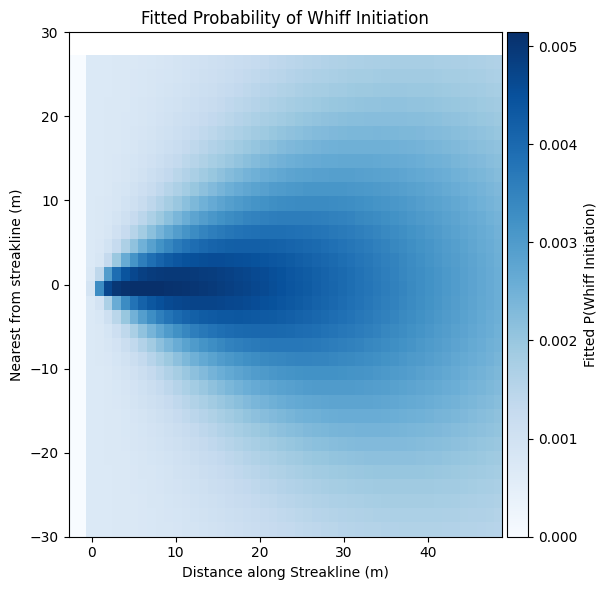

In [6]:
def directional_gaussian_plume(x, y, A, x0, y0, base_sigma_x, base_sigma_y, theta, distance_scale_factor_x,distance_scale_factor_y):
    """Calculate a directional Gaussian plume model with dynamic spread."""
    distance_from_source = np.sqrt((x - x0)**2 + (y - y0)**2)
    sigma_x = base_sigma_x + distance_scale_factor_x * distance_from_source
    sigma_y = base_sigma_y + distance_scale_factor_y * distance_from_source
    
    xp = np.cos(theta) * (x - x0) - np.sin(theta) * (y - y0)
    yp = np.sin(theta) * (x - x0) + np.cos(theta) * (y - y0)
    plume_model = A * np.exp(-((xp)**2 / (2 * sigma_x**2)) - ((yp)**2 / (2 * sigma_y**2)))
    plume_model[x<-0.5]=0
    return plume_model


# Prepare bin centers (same as before)
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
X_centers, Y_centers = np.meshgrid(x_centers, y_centers, indexing='ij')

# Flatten arrays
X_flat = X_centers.flatten()
Y_flat = Y_centers.flatten()
k_obs = heatmap_whiff.flatten()
n_obs = heatmap_total.flatten()

# Exclude bins with zero observations
valid_bins = n_obs > 0
X_flat = X_flat[valid_bins]
Y_flat = Y_flat[valid_bins]
k_obs = k_obs[valid_bins]
n_obs = n_obs[valid_bins]


def negative_log_likelihood(params, x, y, k, n):
    A, x0, y0, sigma_x, sigma_y, theta, distance_scale_factor_x,distance_scale_factor_y = params
    p = directional_gaussian_plume(x, y, A, x0, y0, sigma_x, sigma_y, theta, distance_scale_factor_x,distance_scale_factor_y)
    epsilon = 1e-10
    p = np.clip(p, epsilon, 1 - epsilon)
    ll = k * np.log(p) + (n - k) * np.log(1 - p)
    return -np.sum(ll)


# initial_params = [1.0, 0.0, 0.0, 50, 5, 0.0, 0.01, 0.1] # A, x0, y0, sigma_x, sigma_y, theta, dist_scale_x, dist_scale_y
initial_params = [1.0, 0.0, 0.0, 30, 3, 0.0, 0.02, 0.08] # A, x0, y0, sigma_x, sigma_y, theta, dist_scale_x, dist_scale_y

# Bounds as discussed
bounds = [
    (0, 1),    # A ≥ 0
    (0, 0), # x0 unbounded
    (0, 0), # y0 unbounded
    (1e-5, None), # sigma_x ≥ 1e-5
    (1e-5, None), # sigma_y ≥ 1e-5
    (0, np.pi),  # theta ∈ [-π, π]
    (0,0.02),
    (0,0.5)
]

# Perform the optimization
result = minimize(
    negative_log_likelihood,
    initial_params,
    args=(X_flat, Y_flat, k_obs, n_obs),
    bounds=bounds,
    method='L-BFGS-B'
)

# Extract optimal parameters
optimal_params = result.x
print("Optimal Parameters:")
print(f"A = {optimal_params[0]}")
print(f"x0 = {optimal_params[1]}")
print(f"y0 = {optimal_params[2]}")
print(f"sigma_x = {optimal_params[3]}")
print(f"sigma_y = {optimal_params[4]}")
print(f"theta = {optimal_params[5]}")

# Compute fitted probabilities50
fitted_p = directional_gaussian_plume(
    X_centers, Y_centers, *optimal_params
)
fitted_p_heatmap = fitted_p.reshape(heatmap_prob.shape)


# Plotting
f,ax=plt.subplots(1,1,figsize=(6, 6))
cax =ax.imshow(
    fitted_p_heatmap.T,
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap='Blues'
)

divider = make_axes_locatable(ax)
cbar = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax, cax=cbar, label='Fitted P(Whiff Initiation)')
ax.set_xlabel('Distance along Streakline (m)')
ax.set_ylabel('Nearest from streakline (m)')
ax.set_title('Fitted Probability of Whiff Initiation')
ax.set_ylim(-30,30)
f.tight_layout()

In [365]:
fitted_p_heatmap_1=fitted_p_heatmap*4
dfres['spatial_prob'] = 0  # Default to 0 for all rows

for i, row in dfres.iterrows():
    dist_along = row['distance_along_streakline']
    nearest_from = row['nearest_from_streakline']
    
    x_bin = np.digitize([dist_along], xedges)[0] - 1
    y_bin = np.digitize([nearest_from], yedges)[0] - 1

    if (0 <= x_bin < fitted_p_heatmap_1.shape[0] and 0 <= y_bin < fitted_p_heatmap_1.shape[1]):
        spatial_prob = fitted_p_heatmap_1[x_bin, y_bin]
    else:
        spatial_prob = 0  # Default to 0 if outside bounds

    # Assign the spatial probability to the new column
    dfres.at[i, 'spatial_prob'] = spatial_prob

In [673]:
# df_test=dfres[25000:200000]
df_test = dfres[(dfres['time'] >= 3450) & (dfres['time'] <= 5000)]
df_test.reset_index(inplace=True, drop=True)
dt=df_test.master_time[1]-df_test.master_time[0]
time = []
time.append(0)
for i in range(1,len(df_test)):
    time.append(time[i-1]+dt)
    
df_test['time'] = time


def predict_whiff_from_probability(x, y, hmap, xedges, yedges):
    x_bin = np.digitize(x, xedges) - 1  
    y_bin = np.digitize(y, yedges) - 1

    if x_bin < 0 or x_bin >= hmap.shape[0] or y_bin < 0 or y_bin >= hmap.shape[1]:
        return False, 0  # No valid bin, so no whiff predicted, probability is 0
    whiff_prob = hmap[x_bin, y_bin] 
    whiff_predicted = np.random.rand() < whiff_prob  # True if random number is less than the probability

    return whiff_predicted, whiff_prob

distance_threshold = 2
rows_per_second = 200
base_odor_level = 0.58 

odor_concentration_samples = np.full(len(df_test), base_odor_level)
whiff_prediction_samples = np.zeros(len(df_test), dtype=int)

test_locations = df_test[['distance_along_streakline', 'nearest_from_streakline']].values
whiff_locations = fdf[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values
nowhiff_locations = fdf_nowhiff[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values

whiff_means = fdf.mean_concentration.values
whiff_stds = fdf.std_whiff.values
whiff_duration = fdf.length_of_encounter.values
whiff_intermittency=fdf.odor_intermittency.values
nowhiff_means = fdf_nowhiff.wc_nowhiff.values
nowhiff_wsd = fdf_nowhiff.wsd_nowhiff.values

distances = cdist(test_locations, whiff_locations)
distances_nowhiff = cdist(test_locations,nowhiff_locations )

/tmp/ipykernel_341718/3053643318.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['time'] = time


In [674]:
# plt.plot(whiff_intermittency)
# plt.ylabel('Intermittency, s')
# plt.plot(df_test.time,df_test.odor)

In [675]:
def update_whiff_posterior(prior_prob, recent_history, transition_matrix):
    """Update posterior probability based on recent temporal history."""
    whiff_state = 1 if recent_history[-1] else 0
    num_recent_whiffs = sum(recent_history)
    
    # Dynamic boost: Increase posterior if recent whiffs are frequent
    boost_factor = 1 + (num_recent_whiffs / len(recent_history)) * 15  # Scale factor (tuneable)
    
    posterior = prior_prob * transition_matrix[whiff_state][1] * boost_factor
    posterior = posterior / (posterior + (1 - posterior))  # Normalize
    return posterior

def moving_average(data, window_size):
    if window_size < 1 or len(data) < window_size:
        return data  # Return data as is if the window size is too large for the data length
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

# --- Parameters and Transition Matrix ---
transition_matrix = np.array([
    [0.1, 0.8],  # P(Whiff -> Whiff), P(Whiff -> No-Whiff)
    [0.1, 0.8]   # P(No-Whiff -> Whiff), P(No-Whiff -> No-Whiff)
])
alpha = 1             # Scaling factor for distance effect
max_distance = df_test['distance_along_streakline'].max()

# --- Main Simulation Loop ---
warmup_steps = 10 * rows_per_second 
recent_history = [0] * 1600  # Initialize with 10 no-whiff states
posterior = 0 
thx = 40
valid_intermittency = whiff_intermittency[whiff_intermittency < thx]
median_intermittency = np.mean(valid_intermittency)
whiff_intermittency_cleaned = np.where(whiff_intermittency > thx, median_intermittency, whiff_intermittency)

i = 0
while i < len(df_test):
    if i < warmup_steps:
    # Skip prediction during the warm-up period
        i += 1
        continue
    
    dist_along, nearest_from = df_test.iloc[i][['distance_along_streakline', 'nearest_from_streakline']]
    prior_prob = df_test.at[i, 'spatial_prob']
    posterior = update_whiff_posterior(prior_prob * 3, recent_history, transition_matrix)

    whiff_predicted = np.random.rand() < posterior
    whiff_predicted = bool(whiff_predicted)
    recent_history.append(whiff_predicted)
    recent_history.pop(0)

    if whiff_predicted and np.min(distances[i]) <= distance_threshold:
        nearest_whiff_idx = np.argmin(distances[i])
        mean_concentration = whiff_means[nearest_whiff_idx]
        std_dev_whiff = whiff_stds[nearest_whiff_idx]
        duration = int(whiff_duration[nearest_whiff_idx] * rows_per_second)
        rows_to_fill = min(duration, len(df_test) - i)

        generated_concentrations = np.random.normal(mean_concentration, std_dev_whiff, rows_to_fill)
        generated_concentrations = np.clip(generated_concentrations, 4.5, 10.2)

        odor_concentration_samples[i:i + rows_to_fill] = generated_concentrations
        whiff_prediction_samples[i:i + rows_to_fill] = 1
        i += rows_to_fill

        base_intermittency = whiff_intermittency[nearest_whiff_idx]
        # scaled_intermittency = base_intermittency * (0.2 + alpha * (dist_along / max_distance))
        scaled_intermittency = base_intermittency * (0.1 + alpha * (1 - (dist_along / max_distance)))
        intermittency_duration = int(scaled_intermittency * rows_per_second)
        i += intermittency_duration
    else:
        i += 1
# --- Address No Whiff Regions ---
i = 0
while i < len(df_test):
    if odor_concentration_samples[i] == base_odor_level:
        nearest_no_whiff_idx = np.argmin(distances_nowhiff[i])
        no_whiff_mean = nowhiff_means[nearest_no_whiff_idx]
        no_whiff_std = nowhiff_wsd[nearest_no_whiff_idx]

        start = i
        while i < len(df_test) and odor_concentration_samples[i] == base_odor_level:
            i += 1
        end = i

        no_whiff_concentrations = np.random.normal(no_whiff_mean, no_whiff_std, end - start)
        no_whiff_concentrations = np.clip(no_whiff_concentrations, 0.58, 1)

        smoothed_concentrations = moving_average(no_whiff_concentrations, window_size=5)
        odor_concentration_samples[start:end] = smoothed_concentrations
    else:
        i += 1

# --- Update DataFrame with Results ---
df_test['predicted_odor'] = odor_concentration_samples
df_test['whiff_predicted'] = whiff_prediction_samples


/tmp/ipykernel_341718/2684269910.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predicted_odor'] = odor_concentration_samples
/tmp/ipykernel_341718/2684269910.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['whiff_predicted'] = whiff_prediction_samples


In [676]:
# np.savez('/home/gorilla/An/data/simulator/lws/lws_hmap_with_edges.npz', fitted_p_heatmap=fitted_p_heatmap_1, xedges=xedges, yedges=yedges)
# fdf.to_hdf('/home/gorilla/An/data/simulator/lws/whiff.h5',key='fdf', mode='w')

In [677]:
# i = 0
# while i < len(df_test):
#     dist_along, nearest_from = df_test.iloc[i][['distance_along_streakline', 'nearest_from_streakline']]
#     whiff_predicted, whiff_prob = predict_whiff_from_probability(dist_along, nearest_from, 
#                                                                  fitted_p_heatmap_1, xedges, yedges)

#     if whiff_predicted and np.min(distances[i]) <= distance_threshold:
#         nearest_whiff_idx = np.argmin(distances[i])
#         mean_concentration = whiff_means[nearest_whiff_idx]
#         std_dev_whiff = whiff_stds[nearest_whiff_idx]
#         duration = int(whiff_duration[nearest_whiff_idx] * rows_per_second)
#         rows_to_fill = min(duration, len(df_test) - i)

#         generated_concentrations = np.random.normal(mean_concentration, std_dev_whiff, rows_to_fill)
#         generated_concentrations = np.clip(generated_concentrations, 4.5, 10.2)
#         odor_concentration_samples[i:i + rows_to_fill] = generated_concentrations
#         whiff_prediction_samples[i:i + rows_to_fill] = 1
#         i += rows_to_fill  # Move index by the number of filled rows
#     else:
#         i += 1  

# def moving_average(data, window_size):
#     if window_size < 1 or len(data) < window_size:
#         return data  # Return data as is if the window size is too large for the data length
#     window = np.ones(int(window_size))/float(window_size)
#     return np.convolve(data, window, 'same')

# # Step 2: Address No Whiff Regions
# i = 0
# while i < len(df_test):
#     if odor_concentration_samples[i] == base_odor_level:
#         nearest_no_whiff_idx = np.argmin(distances_nowhiff[i])
#         no_whiff_mean = nowhiff_means[nearest_no_whiff_idx]
#         no_whiff_std = nowhiff_wsd[nearest_no_whiff_idx]

#         start = i
#         while i < len(df_test) and odor_concentration_samples[i] == base_odor_level:
#             i += 1
#         end = i

#         no_whiff_concentrations = np.random.normal(no_whiff_mean, no_whiff_std, end - start)
#         no_whiff_concentrations = np.clip(no_whiff_concentrations, 0.58, 1)  # Ensure values are within realistic bounds
#         # odor_concentration_samples[start:end] = no_whiff_concentrations
#         # Apply moving average smoothing
#         smoothed_concentrations = moving_average(no_whiff_concentrations, window_size=5)

#         odor_concentration_samples[start:end] = smoothed_concentrations
#     else:
#         i += 1

# # Update the DataFrame with the results
# df_test['predicted_odor'] = odor_concentration_samples
# df_test['whiff_predicted'] = whiff_prediction_samples

In [678]:
# df_test=df_test[20000:]
# df_test.reset_index(inplace=True, drop=True)
# dt=df_test.master_time[1]-df_test.master_time[0]
# time = []
# time.append(0)
# for i in range(1,len(df_test)):
#     time.append(time[i-1]+dt)
    
# df_test['time'] = time

In [679]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from itertools import product
# from scipy.stats import wasserstein_distance

# max_distance = df_test['distance_along_streakline'].max()
# def cal_stat(df,idx,df2):
#     osc.avg_distance(df,idx,df2)
#     osc.mean_conc(df,idx,df2)
#     osc.whiff_blank_duration(df,idx,df2)
#     osc.std_whiff(df,idx,df2)
#     osc.mean_avg(df,idx,df2)
#     osc.encounter_frequency(df,idx,df2,1,2)
#     osc.mean_t(df,idx,df2)

# def cal_stat_predicted(df,idx,df2):
#     osc.avg_distance(df,idx,df2)
#     osc.predicted_mean_conc(df,idx,df2)
#     osc.whiff_blank_duration(df,idx,df2)
#     osc.std_whiff_predicted(df,idx,df2)
#     osc.mean_avg_predicted(df,idx,df2)
#     osc.encounter_frequency_predicted(df,idx,df2,1,2)
#     osc.mean_t(df,idx,df2)

# def update_whiff_posterior(prior_prob, recent_history, transition_matrix, boost_factor):
#     """Update posterior probability based on recent temporal history."""
#     whiff_state = 1 if recent_history[-1] else 0
#     num_recent_whiffs = sum(recent_history)
    
#     # Dynamic boost: Increase posterior if recent whiffs are frequent
#     boost = 1 + (num_recent_whiffs / len(recent_history)) * boost_factor
    
#     posterior = prior_prob * transition_matrix[whiff_state][1] * boost
#     posterior = posterior / (posterior + (1 - posterior))  # Normalize
#     return posterior

# def run_simulation(boost_factor, alpha, transition_matrix, thx, df_test, distances, whiff_means, whiff_stds, whiff_duration, whiff_intermittency, distances_nowhiff, nowhiff_means, nowhiff_wsd, rows_per_second):
#     # Initialize parameters
#     odor_concentration_samples = np.full(len(df_test), base_odor_level)
#     whiff_prediction_samples = np.zeros(len(df_test), dtype=int)

#     warmup_steps = 10 * rows_per_second
#     recent_history = [0] * 1600
#     posterior = 0
#     odor_concentration_samples = np.zeros(len(df_test))
#     whiff_prediction_samples = np.zeros(len(df_test))

#     # Clean intermittency
#     valid_intermittency = whiff_intermittency[whiff_intermittency < thx]
#     median_intermittency = np.mean(valid_intermittency)
#     whiff_intermittency_cleaned = np.where(whiff_intermittency > thx, median_intermittency, whiff_intermittency)

#     i = 0
#     while i < len(df_test):
#         if i < warmup_steps:
#             i += 1
#             continue

#         dist_along, nearest_from = df_test.iloc[i][['distance_along_streakline', 'nearest_from_streakline']]
#         prior_prob = df_test.at[i, 'spatial_prob']
#         posterior = update_whiff_posterior(prior_prob * 3, recent_history, transition_matrix, boost_factor)

#         whiff_predicted = np.random.rand() < posterior
#         whiff_predicted = bool(whiff_predicted)
#         recent_history.append(whiff_predicted)
#         recent_history.pop(0)

#         if whiff_predicted and np.min(distances[i]) <= distance_threshold:
#             nearest_whiff_idx = np.argmin(distances[i])
#             mean_concentration = whiff_means[nearest_whiff_idx]
#             std_dev_whiff = whiff_stds[nearest_whiff_idx]
#             duration = int(whiff_duration[nearest_whiff_idx] * rows_per_second)
#             rows_to_fill = min(duration, len(df_test) - i)

#             generated_concentrations = np.random.normal(mean_concentration, std_dev_whiff, rows_to_fill)
#             generated_concentrations = np.clip(generated_concentrations, 4.5, 10.2)

#             odor_concentration_samples[i:i + rows_to_fill] = generated_concentrations
#             whiff_prediction_samples[i:i + rows_to_fill] = 1
#             i += rows_to_fill

#             base_intermittency = whiff_intermittency_cleaned[nearest_whiff_idx]
#             scaled_intermittency = base_intermittency * (0.1 + alpha * (1 - (dist_along / max_distance)))
#             intermittency_duration = int(base_intermittency * rows_per_second)
#             i += intermittency_duration
#         else:
#             i += 1

#     df_test['predicted_odor'] = odor_concentration_samples
#     df_test['whiff_predicted'] = whiff_prediction_samples
#     return df_test


# def objective_function(fdf1, fdf_predicted, whiff_counts_actual_norm, whiff_counts_predicted_norm):
#     # 1. Total Whiff Count Difference
#     actual_whiffs = len(fdf1)
#     predicted_whiffs = len(fdf_predicted)
#     whiff_count_diff = abs(actual_whiffs - predicted_whiffs)
    
#     # 2. Whiff Distribution by Distance
#     whiff_distance_wd = wasserstein_distance(whiff_counts_actual_norm, whiff_counts_predicted_norm)
    
#     # 3. Whiff Frequency vs Distance
#     freq_wd = wasserstein_distance(fdf1['wf'], fdf_predicted['wf'])
    
#     # Combine metrics
#     return whiff_count_diff + whiff_distance_wd + freq_wd

# # --- Grid Search Parameters ---
# boost_factors = [10, 15, 20]
# alphas = [0.5, 1, 1.5]
# transition_matrices = [
#     np.array([[0.1, 0.8], [0.1, 0.8]]),
#     np.array([[0.2, 0.7], [0.2, 0.7]]),
#     np.array([[0.05, 0.9], [0.05, 0.9]])
# ]
# thresholds = [30, 40, 50]

# distance_bins = np.linspace(0, 50, 20)  # Example bin edges for distance

# # --- Grid Search Loop ---
# best_score = float('inf')
# best_params = None

# for boost, alpha, tm, thx in product(boost_factors, alphas, transition_matrices, thresholds):
#     simulated_df = run_simulation(boost, alpha, tm, thx, df_test, distances, whiff_means, whiff_stds, whiff_duration, whiff_intermittency, distances_nowhiff, nowhiff_means, nowhiff_wsd, rows_per_second)
    
#     # Create DataFrames for actual and predicted whiffs based on the threshold
#     th = 4.5
#     new_test_df1 = simulated_df[simulated_df['odor'] > th].reset_index(drop=True)
#     new_test_df2 = simulated_df[simulated_df['predicted_odor'] > th].reset_index(drop=True)
    
#     # Calculate whiff statistics
#     fdf1 = pd.DataFrame()
#     fdf_predicted = pd.DataFrame()
#     cal_stat(new_test_df1, osc.get_index(new_test_df1.odor, th), fdf1)
#     cal_stat_predicted(new_test_df2, osc.get_index(new_test_df2.predicted_odor, th), fdf_predicted)
    
#     # Calculate whiff counts binned by distance
#     n_bins = 20
#     bins = np.linspace(0, new_test_df1['distance_from_source'].max(), n_bins + 1)
#     whiff_counts_actual = new_test_df1.groupby(pd.cut(new_test_df1['distance_from_source'], bins=bins)).size()
#     whiff_counts_predicted = new_test_df2.groupby(pd.cut(new_test_df2['distance_from_source'], bins=bins)).size()
    
#     # Normalize whiff counts
#     whiff_counts_actual_norm = whiff_counts_actual / whiff_counts_actual.max()
#     whiff_counts_predicted_norm = whiff_counts_predicted / whiff_counts_predicted.max()
    
#     # Calculate the score using the objective function
#     score = objective_function(fdf1, fdf_predicted, whiff_counts_actual_norm, whiff_counts_predicted_norm)

#     # Track the best parameters
#     if score < best_score:
#         best_score = score
#         best_params = (boost, alpha, tm, thx)

# print(f"Best Score: {best_score}")
# print(f"Best Parameters: Boost Factor: {best_params[0]}, Alpha: {best_params[1]}, Transition Matrix: {best_params[2]}, Threshold: {best_params[3]}")



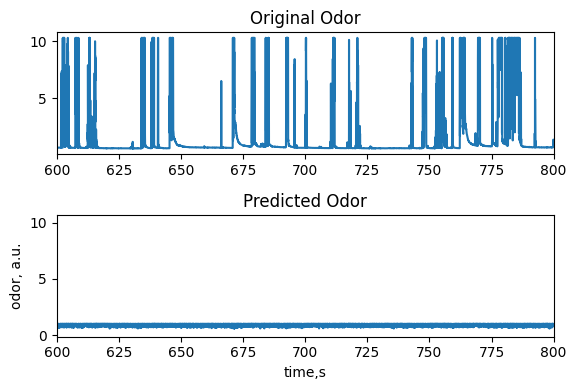

In [680]:
f,(ax1,ax2)= plt.subplots(2,1,figsize=(6,4))
ax1.plot(df_test.time, df_test.odor, label='original')
# plt.plot(df_test.smoothed_odor, label='smoothed')
ax2.plot(df_test.time, df_test.predicted_odor, label='predicted')
# ax2.axhline(4, color = 'r', linestyle = '--')

# limit=(2000,2100)
limit = (600,800)
ax1.set_xlim(limit)
ax2.set_xlim(limit)
# ax2.set_ylim(0,1)

ax2.set_ylabel('odor, a.u.')
ax2.set_xlabel('time,s')
ax1.set_title('Original Odor')
ax2.set_title('Predicted Odor')
f.tight_layout()

In [681]:
th=4.5
query1 = 'odor>4.5'
new_test_df1 = df_test.query(query1)
new_test_df1.reset_index(inplace=True, drop=True)

query2 = 'predicted_odor>4.5'
new_test_df2 = df_test.query(query2)
new_test_df2.reset_index(inplace=True, drop=True)



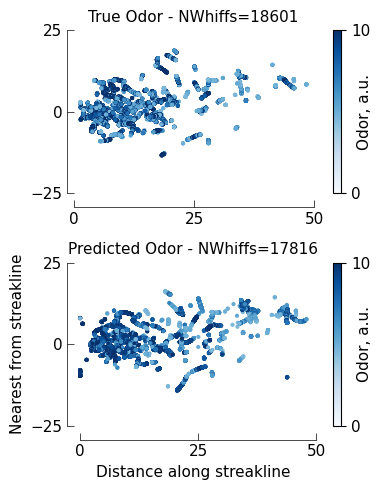

In [682]:
f, ax = plt.subplots(2, 1, figsize=(4, 5))

cax1 = ax[0].scatter(new_test_df1.distance_along_streakline, new_test_df1.nearest_from_streakline, c=new_test_df1.odor, s = 4, cmap='Blues', vmin=0, vmax=10)
cax2 = ax[1].scatter(new_test_df2.distance_along_streakline, new_test_df2.nearest_from_streakline, c=new_test_df2.predicted_odor, s = 4, cmap='Blues', vmin=0, vmax=10)
# cax3 = ax[2].scatter(new_test_df2.distance_along_streakline, new_test_df2.nearest_from_streakline, c=new_test_df2.whiff_predicted, s = 4, cmap='Blues', vmin=0, vmax=1)


# ylim=(-15,25)

ax[0].set_title('True Odor - NWhiffs='+str(len(new_test_df1)))
ax[1].set_title('Predicted Odor - NWhiffs='+str(len(new_test_df2)))

ax[1].set_xlabel('Distance along streakline')
ax[1].set_ylabel('Nearest from streakline')

cb1=plt.colorbar(cax1)
cb2=plt.colorbar(cax2)
# cb3=plt.colorbar(cax3)

cb1.set_label('Odor, a.u.',labelpad=-10)
cb2.set_label('Odor, a.u.',labelpad=-10)
# cb3.set_label('P(Whiff Onset)',labelpad=-10)5

cb1.set_ticks([0,10])
cb2.set_ticks([0,10])
# cb3.set_ticks([0, 1])
for i in range(2):
    mpl_functions.adjust_spines(ax[i],['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[0,25,50],
                            yticks=[-25,0,25],
                            linewidth=0.5)
    mpl_functions.set_fontsize(ax[i],11)

f.tight_layout()

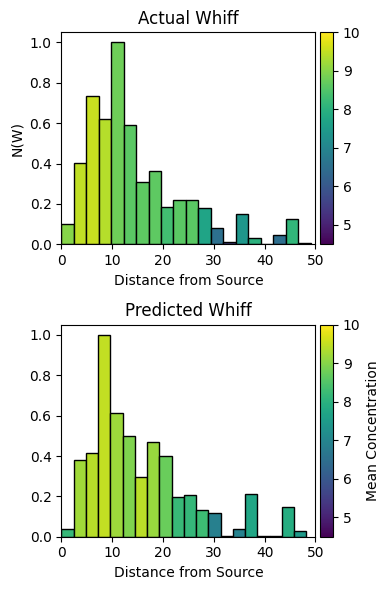

In [671]:
n_bins = 20

# Actual Whiff Data
df_actual = new_test_df1.copy()
bins = np.linspace(0, df_actual['distance_from_source'].max(), n_bins + 1)
df_actual['distance_bin'] = pd.cut(df_actual['distance_from_source'], bins=bins)

whiff_counts_actual = df_actual.groupby('distance_bin').size()
mean_concentrations_actual = df_actual.groupby('distance_bin')['odor'].mean()
bin_centers_actual = (bins[:-1] + bins[1:]) / 2

# Normalize actual whiff counts5
whiff_counts_actual_norm = whiff_counts_actual / whiff_counts_actual.max()

# Predicted Whiff Data
df_predicted = new_test_df2.copy()
bins_predicted = np.linspace(0, df_predicted['distance_from_source'].max(), n_bins + 1)
df_predicted['distance_bin'] = pd.cut(df_predicted['distance_from_source'], bins=bins_predicted)

whiff_counts_predicted = df_predicted.groupby('distance_bin').size()
mean_concentrations_predicted = df_predicted.groupby('distance_bin')['predicted_odor'].mean()
bin_centers_predicted = (bins_predicted[:-1] + bins_predicted[1:]) / 2

# Normalize predicted whiff counts
whiff_counts_predicted_norm = whiff_counts_predicted / whiff_counts_predicted.max()

# Create the subplots
f, ax = plt.subplots(2, 1, figsize=(4, 6))

# Plot for Actual Whiff Data
norm_actual = plt.Normalize(4.5, 10)
colors_actual = plt.cm.viridis(norm_actual(mean_concentrations_actual))
bars_actual = ax[0].bar(bin_centers_actual, whiff_counts_actual_norm, width=(bins[1] - bins[0]), edgecolor='black', color=colors_actual)

divider_actual = make_axes_locatable(ax[0])
cax_actual = divider_actual.append_axes("right", size="5%", pad=0.05)
sm_actual = plt.cm.ScalarMappable(cmap='viridis', norm=norm_actual)
sm_actual.set_array([])
cbar_actual = plt.colorbar(sm_actual, cax=cax_actual)

ax[0].set_xlabel('Distance from Source')
ax[0].set_ylabel('N(W)')
ax[0].set_title('Actual Whiff')
# ax[0].set_ylim(0, 1)
ax[0].set_xlim(0, 50)

# Plot for Predicted Whiff Data
norm_predicted = plt.Normalize(4.5, 10)
colors_predicted = plt.cm.viridis(norm_predicted(mean_concentrations_predicted))
bars_predicted = ax[1].bar(bin_centers_predicted, whiff_counts_predicted_norm, width=(bins_predicted[1] - bins_predicted[0]), edgecolor='black', color=colors_predicted)

divider_predicted = make_axes_locatable(ax[1])
cax_predicted = divider_predicted.append_axes("right", size="5%", pad=0.05)
sm_predicted = plt.cm.ScalarMappable(cmap='viridis', norm=norm_predicted)
sm_predicted.set_array([])
cbar_predicted = plt.colorbar(sm_predicted, cax=cax_predicted)
cbar_predicted.set_label('Mean Concentration')

ax[1].set_xlabel('Distance from Source')
ax[1].set_title('Predicted Whiff')
# ax[1].set_ylim(0, 1)
ax[1].set_xlim(0, 50)

f.tight_layout()



### WHIFF STAT PLOTS

In [672]:
new_test_df1=df_test.copy()
new_test_df2=df_test.copy()

In [651]:
def cal_stat(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff(df,idx,df2)
    osc.mean_avg(df,idx,df2)
    osc.encounter_frequency(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)

def cal_stat_predicted(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.predicted_mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff_predicted(df,idx,df2)
    osc.mean_avg_predicted(df,idx,df2)
    osc.encounter_frequency_predicted(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)
th = 4.5
np.seterr(divide='ignore')
index = osc.get_index(new_test_df1.odor,th)
index_predicted = osc.get_index(new_test_df2.predicted_odor,th)
fdf1 = pd.DataFrame()
fdf_predicted = pd.DataFrame()

cal_stat(new_test_df1,index,fdf1)
cal_stat_predicted(new_test_df2,index_predicted, fdf_predicted)

fdf1.keys()

/home/gorilla/An/plume_sim/odor_stat_calculations.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.efreq.iloc[start] = 1


Index(['avg_dist_from_source', 'log_avg_dist_from_source',
       'mean_concentration', 'length_of_encounter', 'odor_intermittency',
       'log_whiff', 'log_blank', 'std_whiff', 'whiff_ma', 'wf', 'mean_time'],
      dtype='object')

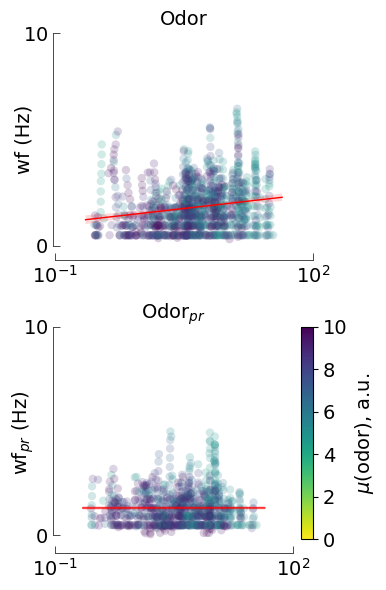

In [652]:
### WHIFF FREQUENCY5
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 6))

# Plot for actual odor
var = ax1.scatter(fdf1.log_avg_dist_from_source, fdf1.wf, c=fdf1.mean_concentration, cmap='viridis_r', edgecolors='none',
                  alpha=0.2, vmin=0, vmax=10)
ax1.set_ylabel('Whiff Frequency (Hz)')

g1 = sns.regplot(x=fdf1.log_avg_dist_from_source, y=fdf1.wf, data=fdf1,
                 ax=ax1, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)
ax1.set_ylim(0,)
ax1.set_title('Odor')

# Plot for predicted odor
u = ax2.scatter(fdf_predicted.log_avg_dist_from_source, fdf_predicted.wf, c=fdf_predicted.mean_concentration,
                cmap='viridis_r', edgecolors='none', alpha=0.2, vmin=0, vmax=10)

g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source, y=fdf_predicted.wf, data=fdf_predicted,
                 ax=ax2, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

# Add color bar only for the predicted odor plot
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(u, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(odor), a.u.')

# Set the titles and labels
ax2.set_title('Odor$_{pr}$')
ax1.yaxis.set_label_coords(-0.08, 0.5)
ax2.yaxis.set_label_coords(-0.08, 0.5)
ax1.set_ylabel('wf (Hz)')
ax2.set_ylabel('wf$_{pr}$ (Hz)')

# Adjust spines for both plots
mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0, 2],
                            yticks=[0, 10],                                    
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0, 2],
                            yticks=[0, 10],
                            linewidth=0.5)

ax1.set_ylim(0,)

# Set custom tick labels
ax1.set_yticklabels([r'$0$', r'$10$'])
ax1.set_xticklabels([r'$10^{-1}$', r'$10^{2}$'])
ax2.set_yticklabels([r'$0$', r'$10$'])
ax2.set_xticklabels([r'$10^{-1}$', r'$10^{2}$'])

# Set font size and layout
mpl_functions.set_fontsize(f, 14)
f.tight_layout()

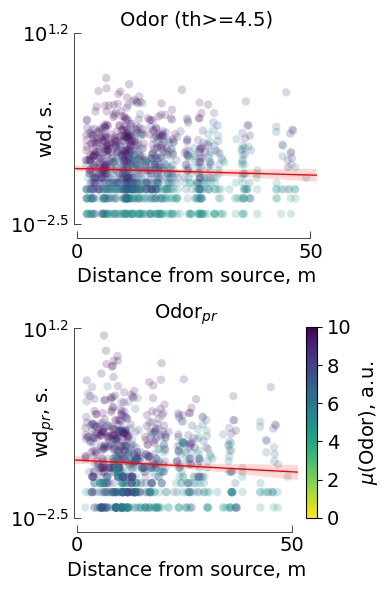

In [504]:
### WHIFF DURATION
f,(ax1,ax2)=plt.subplots(2,1,figsize=(4,6))
var = ax1.scatter(fdf1.avg_dist_from_source,fdf1.log_whiff, c=fdf1.mean_concentration, cmap='viridis_r',edgecolors='none', 
                 alpha=0.2,vmin=0,vmax=10  )
ax1.set_ylabel('$\mu$(WC), a.u.')

g1 = sns.regplot(x=fdf1.avg_dist_from_source,y=fdf1.log_whiff , data=fdf,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

ax1.set_xlabel('Distance from source, m')
ax1.set_ylabel('wd, s.')
ax1.set_title('Odor (th>='+str(th)+')')
ax1.yaxis.set_label_coords(-0.08, 0.5)

u=ax2.scatter(fdf_predicted.avg_dist_from_source,
              fdf_predicted.log_whiff, 
              c=fdf_predicted.mean_concentration, cmap='viridis_r',edgecolors='none', 
                 alpha=0.2, vmin=0,vmax=10)

g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source,y=fdf_predicted.log_whiff , data=fdf_predicted,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(Odor), a.u.')

ax2.set_xlabel('Distance from source, m')
ax2.set_title('Odor$_{pr}$')
ax2.set_ylabel('wd$_{pr}$, s.')
ax2.yaxis.set_label_coords(-0.08, 0.5)
mpl_functions.adjust_spines(ax1,['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[0,50],
                            yticks=[-2.5,1.2],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2,['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[0,50],
                            yticks=[-2.5,1.2],
                            linewidth=0.5)
ax1.set_yticklabels([r'$10^{-2.5}$',r'$10^{1.2}$'])
# ax1.set_xticklabels([r'$10^{-0.5}$',r'$10^{1.8}$'])
ax2.set_yticklabels([r'$10^{-2.5}$',r'$10^{1.2}$'])
# ax2.set_xticklabels([r'$10^{-0.5}$',r'$10^{1.8}$'])

mpl_functions.set_fontsize(f, 14)
f.tight_layout()


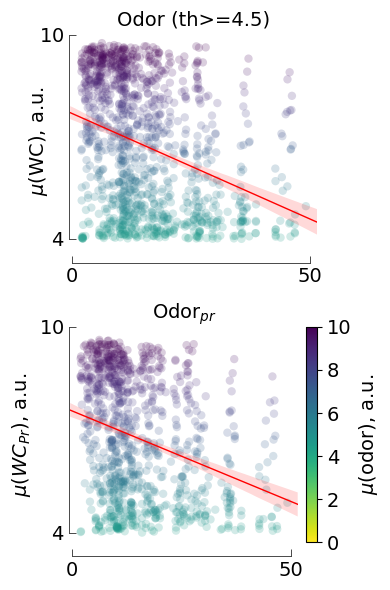

In [503]:
### Whiff concentration
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 6))

# Plot for actual odor
var1 = ax1.scatter(fdf1.avg_dist_from_source, fdf1.mean_concentration, c=fdf1.mean_concentration, cmap='viridis_r', edgecolors='none',
                   alpha=0.2, vmin=0, vmax=10)


g1 = sns.regplot(x=fdf1.avg_dist_from_source, y=fdf1.mean_concentration, data=fdf1,
                 ax=ax1, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.08)
# cbar = f.colorbar(var1, cax=cax, orientation='vertical')
# cbar.solids.set(alpha=1)
# cbar.set_label('$\mu$(WC), a.u.')

# ax1.set_xlabel('Distance from source (log), m')
ax1.set_title('Odor (th>=' + str(th) + ')')
ax1.yaxis.set_label_coords(-0.08, 0.5)

# Plot for predicted odor
var2 = ax2.scatter(fdf_predicted.avg_dist_from_source, fdf_predicted.mean_concentration, c=fdf_predicted.mean_concentration,
                   cmap='viridis_r', edgecolors='none', alpha=0.2, vmin=0, vmax=10)

g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source, y=fdf_predicted.mean_concentration, data=fdf_predicted,
                 ax=ax2, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(var2, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(odor), a.u.')

# ax2.set_xlabel('Distance from source (log), m')
ax2.set_title('Odor$_{pr}$')
ax1.set_ylabel('$\mu$(WC), a.u.')
ax2.set_ylabel('$\mu(WC_{Pr})$, a.u.')
# Adjust spines for both plots
mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0,50],
                            yticks=[4.5, 10.5],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0,50],
                            yticks=[4.5, 10.5],
                            linewidth=0.5)

# Set custom tick labels
ax1.set_yticklabels([r'$4$', r'$10$'])
# ax1.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])
ax2.set_yticklabels([r'$4$', r'$10$'])
# ax2.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])

# Set font size and layout
mpl_functions.set_fontsize(f, 14)
f.tight_layout()


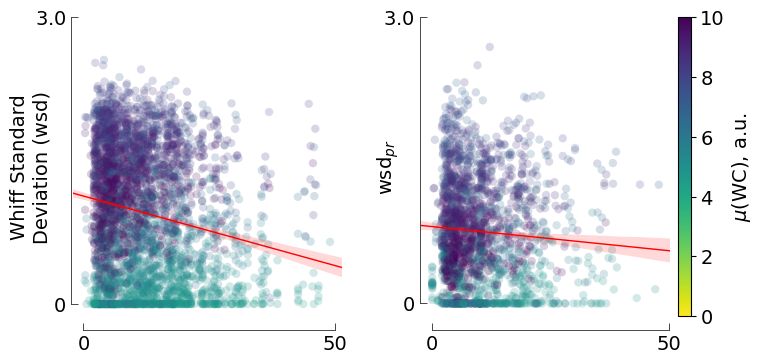

In [344]:
### WHIFF STANDARD DEVIATION
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot for actual odor
var = ax1.scatter(fdf1.avg_dist_from_source, fdf1.std_whiff, c=fdf1.mean_concentration, cmap='viridis_r', edgecolors='none',
                  alpha=0.2, vmin=0, vmax=10)

g1 = sns.regplot(x=fdf1.avg_dist_from_source, y=fdf1.std_whiff, data=fdf1,
                 ax=ax1, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

# Remove color bar for the actual odor plot
# ax1.set_xlabel('Distance from source (log), m')
# ax1.set_title('Actual Odor (th>=' + str(th) + ')')

# Plot for predicted odor
u = ax2.scatter(fdf_predicted.avg_dist_from_source, fdf_predicted.std_whiff, c=fdf_predicted.mean_concentration,
                cmap='viridis_r', edgecolors='none', alpha=0.2, vmin=0, vmax=10)

g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source, y=fdf_predicted.std_whiff, data=fdf_predicted,
                 ax=ax2, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

# Add color bar only for the predicted odor plot
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(u, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# Set the titles and labels
# ax2.set_title('Predicted Odor')
ax1.set_ylabel('Whiff Standard\nDeviation (wsd)')
ax2.set_ylabel('wsd$_{pr}$')
ax1.yaxis.set_label_coords(-0.08, 0.5)
ax2.yaxis.set_label_coords(-0.08, 0.5)
# Adjust spines for both plots
mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0, 50],
                            yticks=[0, 3.0],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0, 50],
                            yticks=[0, 3.0],
                            linewidth=0.5)

# Set custom tick labels
ax1.set_yticklabels([r'$0$', r'$3.0$'])
# ax1.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])
ax2.set_yticklabels([r'$0$', r'$3.0$'])
# ax2.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])

# Set font size and layout
mpl_functions.set_fontsize(f, 14)
f.tight_layout(pad=2)


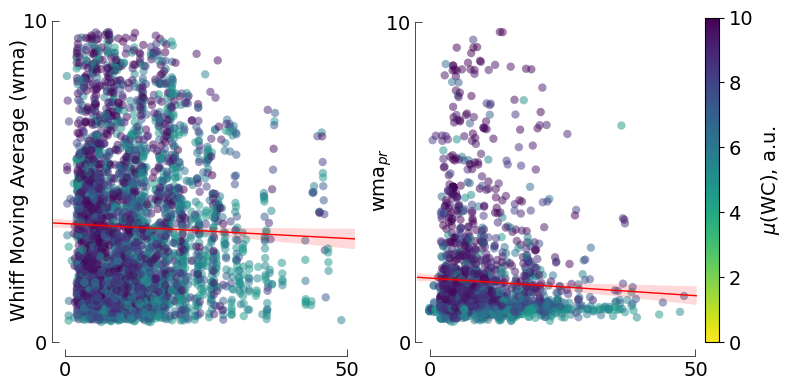

In [345]:
### WHIFF MOVING AVERAGE
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot for actual odor
var = ax1.scatter(fdf1.avg_dist_from_source, fdf1.whiff_ma, c=fdf1.mean_concentration, cmap='viridis_r', edgecolors='none',
                  alpha=0.5, vmin=0, vmax=10)
ax1.set_ylabel('Whiff Moving Average (wma)')

g1 = sns.regplot(x=fdf1.avg_dist_from_source, y=fdf1.whiff_ma, data=fdf1,
                 ax=ax1, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

# Remove color bar for the actual odor plot
# ax1.set_xlabel('Distance from source (log), m')
# ax1.set_title('Actual Odor (th>=' + str(th) + ')')

# Plot for predicted odor
u = ax2.scatter(fdf_predicted.avg_dist_from_source, fdf_predicted.whiff_ma, c=fdf_predicted.mean_concentration,
                cmap='viridis_r', edgecolors='none', alpha=0.5, vmin=0, vmax=10)

g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source, y=fdf_predicted.whiff_ma, data=fdf_predicted,
                 ax=ax2, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

# Add color bar only for the predicted odor plot
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(u, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# Set the titles and labels
# ax2.set_title('Predicted Odor')
ax1.set_ylabel('Whiff Moving Average (wma)')
ax2.set_ylabel('wma$_{pr}$')
ax1.yaxis.set_label_coords(-0.08, 0.5)
ax2.yaxis.set_label_coords(-0.08, 0.5)
# Adjust spines for both plots
mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0, 50],
                            yticks=[0, 10.5],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0, 50],
                            yticks=[0, 10],
                            linewidth=0.5)

# Set custom tick labels
ax1.set_yticklabels([r'$0$', r'$10$'])
# ax1.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])
ax2.set_yticklabels([r'$0$', r'$10$'])
# ax2.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])

# Set font size and layout
mpl_functions.set_fontsize(f, 14)
f.tight_layout()


In [27]:
import statsmodels.formula.api as smf
def create_class_column(dataframe):
    dataframe.loc[dataframe.avg_dist_from_source < 10, 'type'] = 0
    dataframe.loc[(dataframe.avg_dist_from_source >= 10)  & (dataframe.avg_dist_from_source < 20), 'type'] = 1
    dataframe.loc[dataframe.avg_dist_from_source >= 20, 'type'] = 2
    return dataframe

fdf_new = create_class_column(fdf1)
fdf_predicted_new = create_class_column(fdf_predicted)



In [28]:

lookback_time = 10

trainset= fdf_new

D_train=[]
mean_time_train=[]
Xtrain = []
ytrain = []
Nrows_train = []

for distance_class in [0,1,2]:
    Xtrain, ytrain, D_train, Nrows_train,mean_time_train = osc.gather_stat_timed(trainset, distance_class,
                      lookback_time, Xtrain, ytrain, D_train, Nrows_train,
                      mean_time_train)
    
def calc_val(X):
    return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])

column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_k',
             'wf_min','wf_max','wf_mean','wf_std_dev','wf_k',
             'wd_min','wd_max','wd_mean','wd_std_dev','wd_k',
             'ma_min','ma_max','ma_mean','ma_std_dev','ma_k',
             'st_min','st_max','st_mean','st_std_dev','st_k']

traindf=pd.DataFrame(columns = column_names)
c1=[]
for i in range(len(Xtrain)):
    if(np.size(Xtrain[i])==0):
        c1.append(i)
        continue
    else:
        X=[]
        for j in range(len(Xtrain[i])):
            X.append(calc_val(Xtrain[i][j]))
        traindf.loc[i]=np.ravel(X)
        
traindf['distance']=np.delete(D_train, c1)
traindf['mean_whiff_time'] = np.delete(mean_time_train, c1)
traindf['nwhiffs'] = np.delete(Nrows_train, c1)

/tmp/ipykernel_197464/748465162.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_197464/748465162.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_197464/748465162.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_197464/748465162.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs w

In [29]:
distance=smf.ols(formula=""" distance ~ mc_mean + ma_std_dev + ma_max + wd_std_dev """, data=traindf).fit()
print(distance.summary())

                            OLS Regression Results                            
Dep. Variable:               distance   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     118.2
Date:                Tue, 29 Oct 2024   Prob (F-statistic):           5.94e-87
Time:                        15:56:02   Log-Likelihood:                -4965.7
No. Observations:                1409   AIC:                             9941.
Df Residuals:                    1404   BIC:                             9968.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     41.0608      1.388     29.575      0.0

In [30]:
lookback_time = 10

trainset_predicted= fdf_predicted_new

D_train_predicted=[]
mean_time_train_predicted=[]
Xtrain_predicted = []
ytrain_predicted = []
predictions_filled = []
mean_time_train_predicted = []
Nrows_train_predicted = []

for distance_class in [0,1,2]:
    Xtrain_predicted, ytrain_predicted, D_train_predicted, Nrows_train_predicted , mean_time_train_predicted = osc.gather_stat_timed(trainset, distance_class,
                      lookback_time, Xtrain_predicted, ytrain_predicted, D_train_predicted, Nrows_train_predicted,
                      mean_time_train_predicted)
    
def calc_val(X):
    return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])

column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_k',
             'wf_min','wf_max','wf_mean','wf_std_dev','wf_k',
             'wd_min','wd_max','wd_mean','wd_std_dev','wd_k',
             'ma_min','ma_max','ma_mean','ma_std_dev','ma_k',
             'st_min','st_max','st_mean','st_std_dev','st_k']

traindf_predicted=pd.DataFrame(columns = column_names)
c1=[]
for i in range(len(Xtrain_predicted)):
    if(np.size(Xtrain_predicted[i])==0):
        c1.append(i)
        continue
    else:
        X=[]
        for j in range(len(Xtrain_predicted[i])):
            X.append(calc_val(Xtrain_predicted[i][j]))
        traindf_predicted.loc[i]=np.ravel(X)
        
traindf_predicted['distance']=np.delete(D_train_predicted, c1)
traindf_predicted['mean_whiff_time'] = np.delete(mean_time_train_predicted, c1)

/tmp/ipykernel_197464/3085608115.py:19: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_197464/3085608115.py:19: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_197464/3085608115.py:19: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_197464/3085608115.py:19: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occu

In [31]:
distance=smf.ols(formula=""" distance ~ mc_mean + ma_std_dev + ma_max + wd_std_dev """, data=traindf_predicted).fit()
print(distance.summary())

                            OLS Regression Results                            
Dep. Variable:               distance   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     127.4
Date:                Tue, 29 Oct 2024   Prob (F-statistic):           6.32e-93
Time:                        15:56:08   Log-Likelihood:                -5007.4
No. Observations:                1419   AIC:                         1.002e+04
Df Residuals:                    1414   BIC:                         1.005e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     42.5748      1.407     30.250      0.0

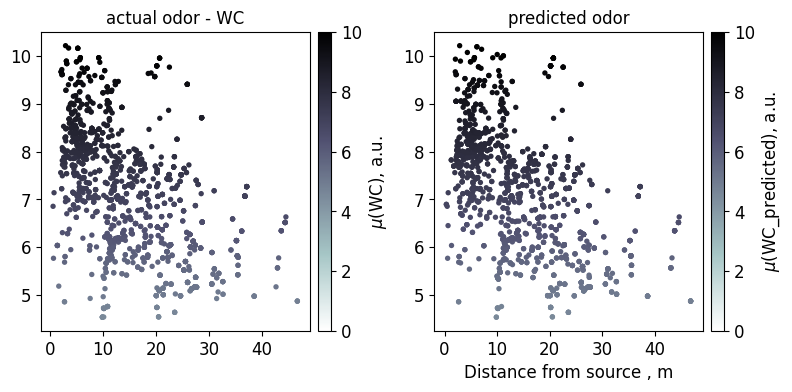

In [33]:
## whiff concentration
f,ax = plt.subplots(1,2,figsize=(8,4))
var1 =ax[0].scatter(traindf.distance, traindf.mc_mean, c=traindf.mc_mean, cmap='bone_r', edgecolors='none', s=15, vmin=0, vmax=10)

divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# g1 = sns.regplot(x=traindf.distance,y=traindf.mc_mean, data=traindf,
#             ax=ax[0], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)

# g1.set(xlabel=None, ylabel=None)

var2 =ax[1].scatter(traindf_predicted.distance, traindf_predicted.mc_mean,c=traindf_predicted.mc_mean, cmap='bone_r', edgecolors='none', s=15, vmin=0, vmax=10)

# g2 = sns.regplot(x=traindf_predicted.distance,y=traindf_predicted.mc_mean, data=traindf_predicted,
#             ax=ax[1], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)

g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)

cbar1.set_label('$\mu$(WC_predicted), a.u.')
# ax[1].set_ylabel('$\mu$(WC)_predicted, a.u.')
ax[1].set_xlabel('Distance from source , m')

ax[0].set_title('actual odor - WC')
ax[1].set_title('predicted odor')

mpl_functions.set_fontsize(f, 12)
f.tight_layout(pad=1)

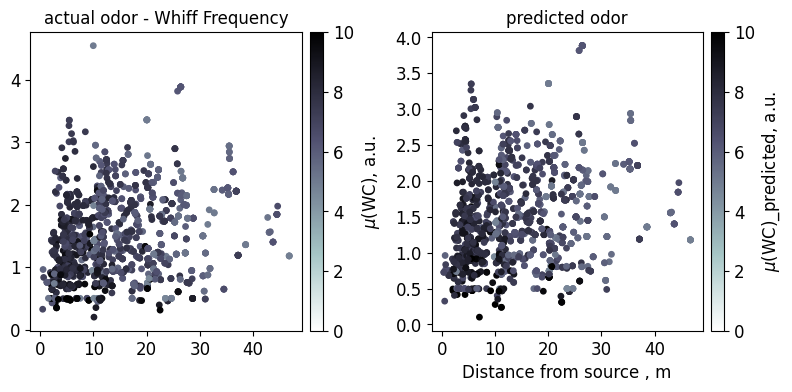

In [34]:
f,ax = plt.subplots(1,2,figsize=(8,4))


var1 =ax[0].scatter(traindf.distance, traindf.wf_mean, c=traindf.mc_mean, cmap='bone_r', s=15 ,vmin=0, vmax=10)

divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# g1 = sns.regplot(x=traindf.distance,y=traindf.mc_mean, data=traindf,
#             ax=ax[0], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)

var2 =ax[1].scatter(traindf_predicted.distance, traindf_predicted.wf_mean,c=traindf_predicted.mc_mean, cmap='bone_r',s=15, vmin=0, vmax=10,)

# g2 = sns.regplot(x=traindf_predicted.distance,y=traindf_predicted.mc_mean, data=traindf_predicted,
#             ax=ax[1], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
# g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')


ax[1].set_xlabel('Distance from source , m')
# ax[0].set_ylabel('$\mu$(WF), a.u.')
# ax[1].set_ylabel('$\mu$(WF)_predicted, a.u.')

ax[0].set_title('actual odor - Whiff Frequency')
ax[1].set_title('predicted odor')

mpl_functions.set_fontsize(f, 12)
f.tight_layout(pad=1)


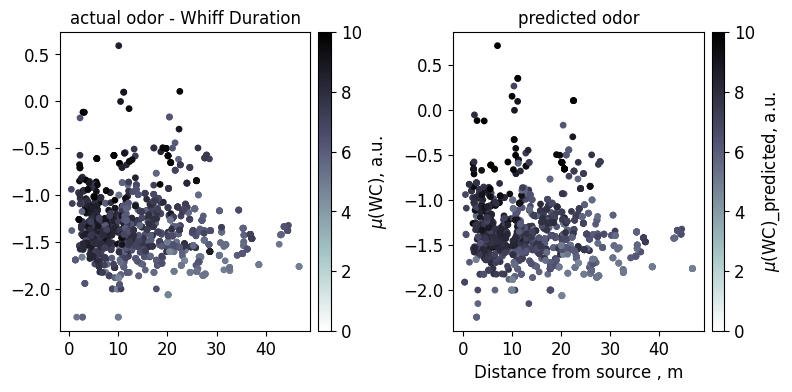

In [35]:
f,ax = plt.subplots(1,2,figsize=(8,4))


var1 =ax[0].scatter(traindf.distance, traindf.wd_mean, c=traindf.mc_mean, cmap='bone_r', s=15, vmin=0, vmax=10)

divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# g1 = sns.regplot(x=traindf.distance,y=traindf.mc_mean, data=traindf, ax=ax[0], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
# g1.set(xlabel=None, ylabel=None)

var2 =ax[1].scatter(traindf_predicted.distance, traindf_predicted.wd_mean,c=traindf_predicted.mc_mean, cmap='bone_r',s=15, vmin=0, vmax=10,)

# g2 = sns.regplot(x=traindf_predicted.distance,y=traindf_predicted.mc_mean, data=traindf_predicted,
#             ax=ax, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
# g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')


ax[1].set_xlabel('Distance from source , m')
# ax[0].set_ylabel('$\mu$(WD), a.u.')
# ax[1].set_ylabel('$\mu$(WD)_predicted, a.u.')
ax[0].set_title('actual odor - Whiff Duration')
ax[1].set_title('predicted odor')

mpl_functions.set_fontsize(f, 12)
f.tight_layout(pad=1)


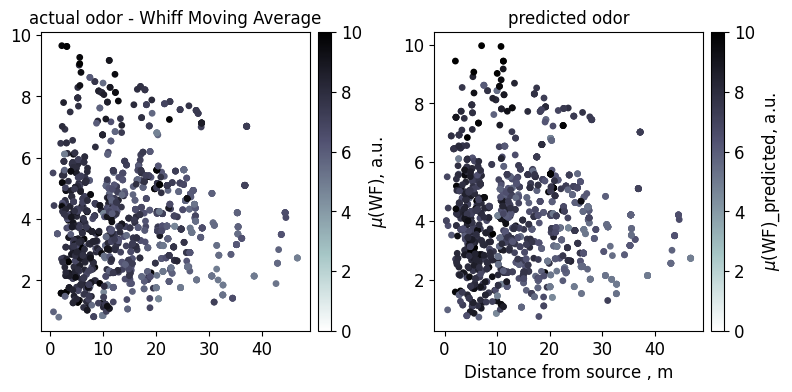

In [36]:
### wma
f,ax = plt.subplots(1,2,figsize=(8,4))


var1 =ax[0].scatter(traindf.distance, traindf.ma_mean, c=traindf.mc_mean, cmap='bone_r', s=15,vmin=0, vmax=10)

divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WF), a.u.')

# g1 = sns.regplot(x=traindf.distance,y=traindf.mc_mean, data=traindf, ax=ax[0], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
# g1.set(xlabel=None, ylabel=None)

var2 =ax[1].scatter(traindf_predicted.distance, traindf_predicted.ma_mean,c=traindf_predicted.mc_mean, cmap='bone_r',s=15, vmin=0, vmax=10,)

# g2 = sns.regplot(x=traindf_predicted.distance,y=traindf_predicted.mc_mean, data=traindf_predicted,
#             ax=ax, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
# g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WF)_predicted, a.u.')


ax[1].set_xlabel('Distance from source , m')
# ax[0].set_ylabel('$\mu$(WMA), a.u.')
# ax[1].set_ylabel('$\mu$(WMA)_predicted, a.u.')

ax[0].set_title('actual odor - Whiff Moving Average')
ax[1].set_title('predicted odor')

mpl_functions.set_fontsize(f, 12)
f.tight_layout(pad=1)


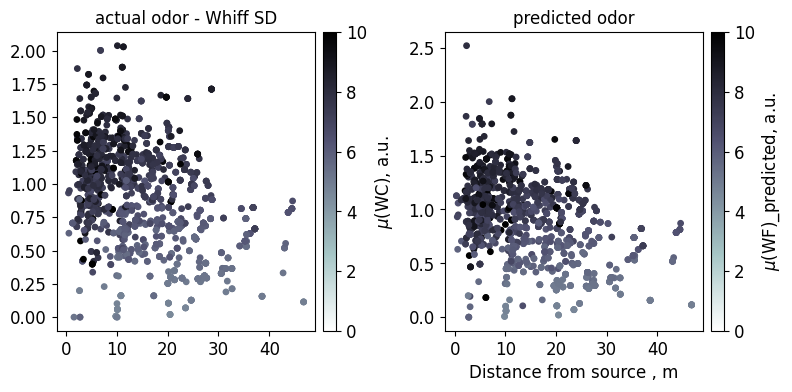

: 

In [37]:
## wsd

f,ax = plt.subplots(1,2,figsize=(8,4))


var1 =ax[0].scatter(traindf.distance, traindf.st_mean, c=traindf.mc_mean, cmap='bone_r',s=15, vmin=0, vmax=10)

divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# g1 = sns.regplot(x=traindf.distance,y=traindf.mc_mean, data=traindf, ax=ax[0], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
# g1.set(xlabel=None, ylabel=None)

var2 =ax[1].scatter(traindf_predicted.distance, traindf_predicted.st_mean,c=traindf_predicted.mc_mean, cmap='bone_r',s=15, vmin=0, vmax=10,)

# g2 = sns.regplot(x=traindf_predicted.distance,y=traindf_predicted.mc_mean, data=traindf_predicted,
#             ax=ax, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
# g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WF)_predicted, a.u.')


ax[1].set_xlabel('Distance from source , m')
# ax[0].set_ylabel('$\mu$(WSD), a.u.')
# ax[1].set_ylabel('$\mu$(WSD)_predicted, a.u.')

ax[0].set_title('actual odor - Whiff SD')
ax[1].set_title('predicted odor')

mpl_functions.set_fontsize(f, 12)
f.tight_layout(pad=1)
